In [1]:
import os
import os.path
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve

import matplotlib.pyplot as plt

import numpy as np
np.random.seed(1)

from keras.preprocessing.image import img_to_array
from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.vgg19 import VGG19
from keras.applications.imagenet_utils import preprocess_input

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
imagedir = "Datasets/Detection/Byteplots"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.png'))  # assuming the images are stored as 'png'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tFamily: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.png'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Family:          Banker	Number of images: 1986
Label: 1	Family:          WinExe	Number of images: 1945
Processing images ...


/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (103265280 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)
/usr/local/lib/python2.7/dist-packages/PIL/Image.py:2371: DecompressionBombWarning: Image size (110601216 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


Images processed: 3931


In [4]:
X.shape

(3931, 224, 224, 3)

In [5]:
# Creating base_model
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = VGG19(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [6]:
print("Extracting bottleneck features from convolutional layers ...")
bnfeatures = base_model.predict(X)

Extracting bottleneck features from convolutional layers ...


In [7]:
bnfeatures.shape

(3931, 512)

In [8]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds                                                                 
skf = StratifiedKFold(kfold, shuffle=True,random_state=1)

In [9]:
# Training top_model
C_range = np.logspace(-2, 3, 6)
gamma_range = np.logspace(-8, 1, 10)
param_grid = dict(gamma=gamma_range, C=C_range)

top_model = GridSearchCV(svm.SVC(), param_grid=param_grid, cv=skf, verbose=10, n_jobs=-1)
top_model.fit(bnfeatures,y)  # Training 

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-08 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-07 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, gamma=1e-06 .............................................
[CV] C=0.01, ga

[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.9s


[CV] C=0.01, gamma=0.001 .............................................
[CV] ............. C=0.01, gamma=0.0001, score=0.908397, total=  21.7s
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505718, total=  28.7s
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total=  29.0s
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total=  29.2s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] C=0.01, gamma=0.001 .............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505718, total=  29.7s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total=  29.6s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] .............. C=0.01, gamma=1e-08, score=0.505089, total=  30.1s
[CV] .

[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:   53.3s


[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total=  29.8s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total=  30.1s
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505089, total=  30.3s
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-06, score=0.505718, total=  30.4s
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-05, score=0.571247, total=  30.7s
[CV] .............. C=0.01, gamma=1e-05, score=0.568702, total=  30.6s
[CV] C=0.01, gamma=1.0 ...............................................
[CV] C=0.01, gamma=1.0 ...............................................
[CV] .............. C=0.01, gamma=1e-07, score=0.505089, total=  30.9s
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   55.1s


[CV] ............. C=0.01, gamma=0.0001, score=0.877863, total=  21.6s
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.815756, total=  28.7s
[CV] C=0.01, gamma=10.0 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.828244, total=  29.0s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.838422, total=  29.1s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.829517, total=  29.6s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .............. C=0.01, gamma=0.001, score=0.824427, total=  29.8s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] ............... C=0.01, gamma=0.01, score=0.505718, total=  29.7s
[CV] C=0.1, gamma=1e-08 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.8min


[CV] ................ C=0.01, gamma=1.0, score=0.505089, total=  28.8s
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505718, total=  29.8s
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total=  29.3s
[CV] C=0.1, gamma=1e-06 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.505089, total=  28.7s
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ................ C=0.01, gamma=0.1, score=0.505089, total=  29.7s
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.505718, total=  29.1s
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] ................ C=0.01, gamma=1.0, score=0.505089, total=  29.9s
[CV] C=0.1, gamma=1e-05 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:  2.1min


[CV] ............... C=0.01, gamma=10.0, score=0.505089, total=  29.4s
[CV] C=0.1, gamma=0.0001 .............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.889454, total=  18.1s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.875318, total=  18.1s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.900763, total=  18.5s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.880407, total=  18.5s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.1, gamma=1e-05, score=0.866412, total=  19.3s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ............... C=0.01, gamma=10.0, score=0.505089, total=  28.9s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:  2.7min


[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total=  30.1s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.594148, total=  30.1s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.599746, total=  30.1s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-06, score=0.597964, total=  30.5s
[CV] C=0.1, gamma=1.0 ................................................
[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total=  30.9s
[CV] C=0.1, gamma=10.0 ...............................................
[CV] ............... C=0.1, gamma=1e-06, score=0.592875, total=  31.0s
[CV] ............... C=0.1, gamma=1e-07, score=0.505089, total=  30.9s
[CV] C=0.1, gamma=10.0 ...............................................
[CV] C=0.1, gamma=10.0 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:  2.8min


[CV] ................ C=0.1, gamma=0.01, score=0.540025, total=  29.3s
[CV] C=1.0, gamma=1e-08 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.534351, total=  29.4s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.535623, total=  29.2s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.527990, total=  30.1s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................ C=0.1, gamma=0.01, score=0.548346, total=  30.3s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=0.1, score=0.518424, total=  30.2s
[CV] C=1.0, gamma=1e-07 ..............................................
[CV] ................. C=0.1, gamma=1.0, score=0.505718, total=  28.9s
[CV] C=1.0, gamma=1e-06 ..............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  3.6min


[CV] C=1.0, gamma=0.0001 .............................................
[CV] ................ C=0.1, gamma=10.0, score=0.505089, total=  29.4s
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505718, total=  31.2s
[CV] C=1.0, gamma=0.0001 .............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total=  31.2s
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total=  31.3s
[CV] C=1.0, gamma=0.001 ..............................................
[CV] ............... C=1.0, gamma=1e-08, score=0.505089, total=  31.3s
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.950445, total=   7.5s
[CV] C=1.0, gamma=0.001 ..............................................
[CV] .............. C=1.0, gamma=0.0001, score=0.945293, total=   7.7s
[CV] C

[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:  3.9min


[CV] ............... C=1.0, gamma=1e-06, score=0.865140, total=  17.9s
[CV] C=1.0, gamma=0.1 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.888183, total=  18.2s
[CV] C=1.0, gamma=0.1 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.881679, total=  18.2s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.951715, total=  13.7s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.874046, total=  18.5s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=1e-06, score=0.899491, total=  18.5s
[CV] C=1.0, gamma=1.0 ................................................
[CV] ............... C=1.0, gamma=0.001, score=0.946565, total=  13.6s
[CV] C=1.0, gamma=1.0 ................................................
[CV] .

[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:  4.7min


[CV] ................ C=1.0, gamma=0.01, score=0.737913, total=  30.0s
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................ C=1.0, gamma=0.01, score=0.764631, total=  30.8s
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.609415, total=  29.4s
[CV] C=10.0, gamma=1e-07 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.595934, total=  29.5s
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=0.1, score=0.606870, total=  30.2s
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.546379, total=  28.6s
[CV] C=10.0, gamma=1e-06 .............................................
[CV] ................. C=1.0, gamma=1.0, score=0.545802, total=  28.7s
[CV] C=10.0, gamma=1e-06 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:  5.1min


[CV] .............. C=10.0, gamma=1e-08, score=0.590331, total=  30.8s
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.601781, total=  31.1s
[CV] C=10.0, gamma=0.001 .............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.596692, total=  31.5s
[CV] C=10.0, gamma=0.001 .............................................
[CV] ............. C=10.0, gamma=0.0001, score=0.964422, total=   6.3s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.940204, total=   7.8s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.940280, total=   7.9s
[CV] C=10.0, gamma=0.01 ..............................................
[CV] .............. C=10.0, gamma=1e-05, score=0.935115, total=   7.7s
[CV] .............. C=10.0, gamma=1e-05, score=0.958015, total=   7.9s
[CV] C

[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  5.3min


[CV] .............. C=10.0, gamma=1e-07, score=0.874046, total=  18.7s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.954198, total=  14.4s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=0.001, score=0.956798, total=  14.4s
[CV] C=10.0, gamma=10.0 ..............................................
[CV] .............. C=10.0, gamma=1e-08, score=0.597964, total=  31.5s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=0.001, score=0.947837, total=  14.2s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=0.001, score=0.974555, total=  14.8s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .............. C=10.0, gamma=0.001, score=0.950382, total=  14.8s
[CV] C=100.0, gamma=1e-08 ............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:  6.1min


[CV] ................ C=10.0, gamma=1.0, score=0.557252, total=  29.1s
[CV] ............. C=100.0, gamma=1e-08, score=0.899491, total=  18.9s
[CV] C=100.0, gamma=1e-05 ............................................
[CV] C=100.0, gamma=1e-05 ............................................
[CV] ................ C=10.0, gamma=1.0, score=0.567430, total=  28.7s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............. C=100.0, gamma=1e-08, score=0.881679, total=  18.9s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ................ C=10.0, gamma=1.0, score=0.559796, total=  30.2s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............... C=10.0, gamma=10.0, score=0.526048, total=  29.8s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] ............... C=10.0, gamma=10.0, score=0.519084, total=  30.1s
[CV] C=100.0, gamma=0.0001 ...........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:  6.3min


[CV] ............. C=100.0, gamma=1e-07, score=0.912214, total=  11.1s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............... C=10.0, gamma=10.0, score=0.525445, total=  29.7s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.926302, total=  11.9s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.945293, total=  11.6s
[CV] C=100.0, gamma=1.0 ..............................................
[CV] ............... C=10.0, gamma=10.0, score=0.522901, total=  29.9s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.908397, total=  11.0s
[CV] C=100.0, gamma=10.0 .............................................
[CV] ............. C=100.0, gamma=1e-07, score=0.913486, total=  11.3s
[CV] C=100.0, gamma=10.0 .............................................
[CV] .

[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  7.2min


[CV] ............... C=100.0, gamma=0.1, score=0.617048, total=  30.0s
[CV] C=1000.0, gamma=1e-06 ...........................................
[CV] ............... C=100.0, gamma=1.0, score=0.559796, total=  28.7s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=1.0, score=0.548920, total=  30.3s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.611959, total=  30.3s
[CV] ............... C=100.0, gamma=0.1, score=0.611959, total=  30.5s
[CV] ............... C=100.0, gamma=1.0, score=0.545802, total=  28.9s
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] C=1000.0, gamma=1e-05 ...........................................
[CV] ............... C=100.0, gamma=0.1, score=0.618321, total=  31.1s
[CV] C=1000.0, gamma=0.0001 ..........................................
[CV] .

[Parallel(n_jobs=-1)]: Done 284 out of 300 | elapsed:  8.1min remaining:   27.5s


[CV] .............. C=1000.0, gamma=1.0, score=0.567430, total=  25.8s
[CV] .............. C=1000.0, gamma=1.0, score=0.557252, total=  25.6s
[CV] ............. C=1000.0, gamma=10.0, score=0.529262, total=  25.9s
[CV] .............. C=1000.0, gamma=0.1, score=0.618321, total=  26.4s
[CV] ............. C=1000.0, gamma=0.01, score=0.753494, total=  29.2s
[CV] .............. C=1000.0, gamma=1.0, score=0.548920, total=  28.5s
[CV] .............. C=1000.0, gamma=0.1, score=0.611959, total=  29.2s
[CV] ............. C=1000.0, gamma=0.01, score=0.770992, total=  30.3s
[CV] ............. C=1000.0, gamma=0.01, score=0.753181, total=  30.5s
[CV] .............. C=1000.0, gamma=1.0, score=0.559796, total=  28.6s
[CV] ............. C=1000.0, gamma=10.0, score=0.525445, total=  28.3s
[CV] ............. C=1000.0, gamma=10.0, score=0.526048, total=  28.3s
[CV] ............. C=1000.0, gamma=10.0, score=0.522901, total=  22.8s
[CV] .............. C=1000.0, gamma=0.1, score=0.617048, total=  29.2s
[CV] .

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.2min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03]), 'gamma': array([  1.00000e-08,   1.00000e-07,   1.00000e-06,   1.00000e-05,
         1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

In [10]:
top_model.cv_results_

{'mean_fit_time': array([ 23.88160634,  24.11157084,  24.05877166,  24.86112261,
         17.65442328,  23.70533242,  23.82928839,  23.86321063,
         23.39928951,  23.21846361,  25.02463145,  24.53618731,
         24.6357142 ,  15.10350466,   9.59055696,  12.6265202 ,
         23.80957441,  24.41827979,  23.37937503,  23.87902293,
         25.36714253,  25.29111614,  14.68138313,   9.13208361,
          6.17527037,  11.16504984,  24.43038163,  23.94089775,
         23.50577579,  23.41536555,  25.50662618,  15.27456317,
          9.44094114,   6.4260911 ,   5.30158896,  11.81191301,
         24.8541544 ,  23.99634886,  23.33579574,  23.91766505,
         15.20994678,   9.38509455,   6.53353953,   5.39830198,
          5.26796808,  11.34869385,  24.75517149,  24.46530914,
         23.65283813,  23.57299814,   9.3609592 ,   6.61100221,
          5.64004946,   6.07823997,   5.06553621,  11.36471143,
         24.26308546,  23.05975676,  22.68098502,  21.91377697]),
 'mean_score_time': a

In [11]:
top_model.grid_scores_

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 9.9999999999999995e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 9.9999999999999995e-07},
 mean: 0.56652, std: 0.00460, params: {'C': 0.01, 'gamma': 1.0000000000000001e-05},
 mean: 0.88578, std: 0.01254, params: {'C': 0.01, 'gamma': 0.0001},
 mean: 0.82727, std: 0.00736, params: {'C': 0.01, 'gamma': 0.001},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.01},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 0.10000000000000001},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 1.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.01, 'gamma': 10.0},
 mean: 0.50521, std: 0.00025, params: {'C': 0.10000000000000001, 'gamma': 1e-08},
 mean: 0.50521, std: 0.00025, params: {'C': 0.10000000000000001, 'gamma': 9.9999999999999995e-08},
 mean: 0.59400, std: 0.00503, params: {'C': 0.10000000000000001, 'gamma': 9.99999999999

In [12]:
print("Best parameters: %s - score: %0.4f" % (top_model.best_params_, top_model.best_score_))

Best parameters: {'C': 10.0, 'gamma': 0.0001} - score: 0.9644


/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


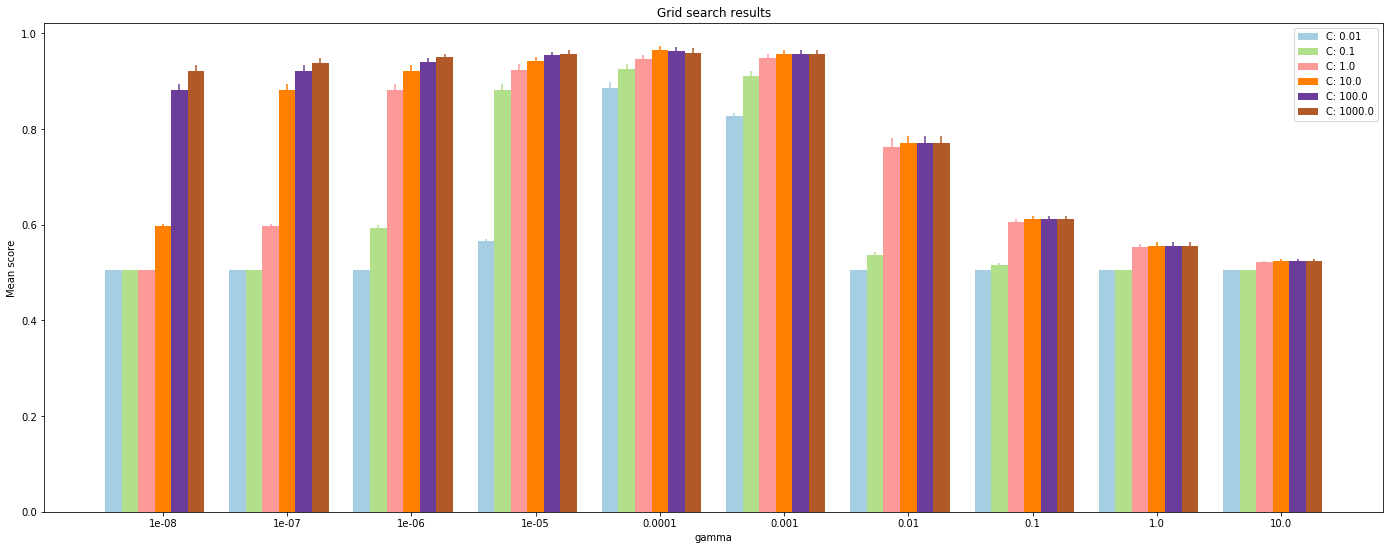

In [13]:
plt.rcParams['image.cmap'] = 'Paired'
skplot.grid_search(top_model.grid_scores_, change='gamma', kind='bar')
figure = plt.gcf()
figure.set_size_inches(24, 9)
plt.show()